<h1> Advanced Learning for Text and Graph Data </h1>
<b> Université Paris-Saclay - Master M2 Data Science - February/March 2017</b> <br>
<i> Students : Peter Martigny & Mehdi Miah </i> <br>

# Third part  : predict and measure the error

## Open the data

In [1]:
#our own modules
from map_tools import * #functions computing mean average precision
from handy_structures import * #functions creating some structures

#common libraries
import os
import pandas as pd
import numpy as np
import time
import random
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import * #progress bar

#for words analysis
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#stemizer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

#tokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') #to remove punctuations

#stopwords and TFIDF
from nltk.corpus import stopwords
all_stopwords = stopwords.words("english")
tfidf = TfidfVectorizer(stop_words = all_stopwords)

In [2]:
#path to data and intermediate results
path_to_data = "../data/"
path_to_results = "../results/"

## == open files ====

#original data
training_set = pd.read_csv(path_to_data + 'training_set.csv')
training_info = pd.read_csv(path_to_data + 'training_info.csv', 
                            dtype = {'mid': object, 'date': object, 'body': object, 'recipients' : object})
test_set = pd.read_csv(path_to_data + 'test_set.csv')
test_info = pd.read_csv(path_to_data + 'test_info.csv',
                        dtype = {'mid': object, 'date': object, 'body': object, 'recipients' : object})

#intermediate data
training_df = pd.read_csv(path_to_results + 'training_df.csv',
                          dtype = {'mid': object, 'sender': object, 'date': object, 'body': object,
                                  'body_rt': object, 'body_rf': object, 'clean_body': object, 'recipients' : object,})
test_df = pd.read_csv(path_to_results + 'test_df.csv',
                          dtype = {'mid': object, 'sender': object, 'date': object, 'body': object, 
                                  'body_rt': object, 'body_rf': object, 'clean_body': object})

In [3]:
training_set.head()

,sender,mids
0,karen.buckley@enron.com,158713 158697 200301 158679 278595 298162 2002...
1,amr.ibrahim@enron.com,215241 3437 215640 3506 191790 3517 3520 3562 ...
2,andrea.ring@enron.com,270705 270706 270707 270708 270709 270710 2707...
3,sylvia.hu@enron.com,111444 111422 183084 111412 111347 110883 1105...
4,phillip.platter@enron.com,327074 327384 327385 264443 274124 274125 2741...


In [4]:
training_info.head()

,mid,date,body,recipients
0,60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...
1,66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...
2,74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...
3,80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com
4,83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...


In [5]:
test_set.head()

,sender,mids
0,karen.buckley@enron.com,298389 332383 298390 284071 366982 81773 81791...
1,amr.ibrahim@enron.com,48260 48465 50344 48268 50330 48237 189979 189...
2,andrea.ring@enron.com,366364 271168 271172 271167 271189
3,sylvia.hu@enron.com,134931 134856 233549 233517 134895 233584 3736...
4,phillip.platter@enron.com,274220 274225 274215 274223 274214 274207 2742...


In [6]:
test_info.head()

,mid,date,body
0,1577,2001-11-19 06:59:51,Note: Stocks of heating oil are very high for...
1,1750,2002-03-05 08:46:57,"Kevin Hyatt and I are going for ""sghetti"" at S..."
2,1916,2002-02-13 14:17:39,This was forwarded to me and it is funny. - Wi...
3,2094,2002-01-22 11:33:56,I will be in to and happy to assist too. I ma...
4,2205,2002-01-11 07:12:19,Thanks. I needed a morning chuckle.


In [7]:
training_df.head()

,mid,sender,date,body,recipients,body_rt,body_rf,clean_body
0,9716,michelle.cash@enron.com,1998-12-21 05:29:00,"Brent,Attached is a form indemnification agree...",brent.hendry@enron.com mark.e.taylor@enron.com,"Brent,Attached is a form indemnification agree...","Brent,Attached is a form indemnification agree...",brent attached form indemnification agreement ...
1,7830,christian.yoder@enron.com,1999-03-02 07:30:00,"As you are already aware, the West desk is ma...",elizabeth.sager@enron.com mark.e.taylor@enron....,"As you are already aware, the West desk is ma...","As you are already aware, the West desk is ma...",already aware west desk making efforts introdu...
2,90523,larry.f.campbell@enron.com,1999-05-03 09:44:00,Go for it!George Robinson04/27/99 04:14 PMTo: ...,butch.russell@enron.com george.robinson@enron.com,Go for it!George Robinson04/27/99 04:14 PMTo: ...,NNG Gomez Water DisposalI began discussions r...,nng gomez water disposali began discussions re...
3,89618,larry.f.campbell@enron.com,1999-05-05 05:27:00,Just a short message to apprise everyone of th...,william.kendrick@enron.com rick.cates@enron.co...,Just a short message to apprise everyone of th...,Just a short message to apprise everyone of th...,short message apprise everyone cleaning result...
4,89475,larry.f.campbell@enron.com,1999-05-05 05:27:00,Just a short message to apprise everyone of th...,william.kendrick@enron.com rick.cates@enron.co...,Just a short message to apprise everyone of th...,Just a short message to apprise everyone of th...,short message apprise everyone cleaning result...


In [8]:
test_df.head()

,mid,sender,date,body,body_rt,body_rf,clean_body
0,284098,jonathan.mckay@enron.com,2001-11-02 05:25:29,"How is everyone.....mother, child.........fath...","How is everyone.....mother, child.........fath...","How is everyone.....mother, child.........fath...",everyone mother child father hope everything w...
1,272008,dutch.quigley@enron.com,2001-11-02 05:34:55,-----Original Message-----From: \tWesner-Soon...,-----Original Message-----From: Wesner-Soong...,-----Original Message----- FW: Contracts that...,original message fw contracts need xpitted out...
2,49273,james.d.steffes@enron.com,2001-11-02 05:57:55,Janine -Ok for you to cover the whole country....,Janine -Ok for you to cover the whole country....,Janine -Ok for you to cover the whole country....,janine ok cover whole country forgotten discus...
3,71901,kim.ward@enron.com,2001-11-02 06:10:47,when?,when?,when?,NaN
4,82354,barry.tycholiz@enron.com,2001-11-02 06:17:44,WOW.... I am positive that your beautiful wife...,WOW.... I am positive that your beautiful wife...,WOW.... I am positive that your beautiful wife...,wow positive beautiful wife sign hauling three...


# Cross validation

In [9]:
#Need to remove mails when the clean body is empty
training_df = training_df.dropna()
training_df = training_df.reset_index(drop=True)
#One cannot do that for test_df because, otherwise, one would lose some instances.

In [10]:
#choice of cross_validation
# 2 : temporal split with one date (percentage version)
# 1 : pure randomness
# 4 : temporal split for each sender (different dates of split)
# 3 : temporal split with one date (date version)
cv_choice = 3

In [11]:
# All the senders present in the training set
training_all_senders = training_set['sender'].get_values()

### first way : pure randomness

In [12]:
if cv_choice == 1: 
    training_df_train, training_df_test = train_test_split(training_df, test_size=0.2, random_state=0)

    training_df_train = training_df_train.reset_index(drop=True)
    training_df_test = training_df_test.reset_index(drop=True)

### second way : temporal on all emails

In [13]:
if cv_choice == 2 :
    #Temporal separation between training and test
    # already time ordered
    pct_train = 0.8
    limit = round(pct_train * training_df.shape[0])
    training_df_train = training_df[:limit]
    training_df_test = training_df[limit:]

Some users are in the test set and NOT in the train set : mike.carson@enron.com, vkaminski@aol.com and christina.valdez@enron.com !


In [14]:
max(training_df[training_df['sender'] == 'mike.carson@enron.com']['date'])

'2001-10-25 14:08:33'

In [15]:
max(training_df[training_df['sender'] == 'vkaminski@aol.com']['date'])

'2001-10-27 23:23:33'

In [16]:
max(training_df[training_df['sender'] == 'christina.valdez@enron.com']['date'])

'2001-10-25 16:05:47'

### third way : date split

In [17]:
if cv_choice == 3:
    split_date='2001-08-20'
    training_df_train = training_df[training_df.date <= split_date]
    training_df_test = training_df[training_df.date > split_date]
    
    training_df_test = training_df_test.reset_index(drop=True) #reindex

### fourth way : temporal by user

In [18]:
if  cv_choice == 4:
    def split_data_v4(training_df, training_all_senders, pct_train = 0.8):
        #Initialisation of the two dataframe for learning and testing
        training_df_train = pd.DataFrame()
        training_df_test = pd.DataFrame()

        #We fill the values by taking the oldest emails in the train and the newest in test dataframe
        for sender in tqdm(training_all_senders):
            #dataframe with all emails sent by the sender
            training_df_sender = training_df[training_df['sender'] == sender] #non void
            limit = round(pct_train * training_df_sender.shape[0])

            training_df_train_sender = training_df_sender[:limit]
            training_df_test_sender = training_df_sender[limit:]

            training_df_train = training_df_train.append(training_df_train_sender)
            training_df_test = training_df_test.append(training_df_test_sender)

        #put the right index
        training_df_train = training_df_train.reset_index(drop=True)
        training_df_test = training_df_test.reset_index(drop=True)

        return training_df_train, training_df_test

    training_df_train, training_df_test = split_data_v4(training_df, training_all_senders, pct_train = 0.8)

### Creation of auxilaire structure (_info and _set)

In [19]:
# Construction of _set with for each sender, the list of emails

#Training
training_set_train = pd.DataFrame()
for sender in tqdm(training_all_senders): #for each sender
    mids = training_df_train[training_df_train['sender'] == sender]['mid'].values.tolist()
    mids = ' '.join(list(map(str, mids)))
    training_set_train_sender = pd.DataFrame({'sender':[sender], 'mids': [mids]})

    training_set_train = training_set_train.append(training_set_train_sender)

#reorder the columns
training_set_train = training_set_train.reindex_axis(['sender', 'mids'], axis = 1)

#add clean index
training_set_train = training_set_train.reset_index(drop=True)

#Test
training_set_test = pd.DataFrame()
for sender in tqdm(training_all_senders): #for each sender
    mids = training_df_test[training_df_test['sender'] == sender]['mid'].values.tolist()
    mids = ' '.join(list(map(str, mids)))
    training_set_test_sender = pd.DataFrame({'sender':[sender], 'mids': [mids]})

    training_set_test = training_set_test.append(training_set_test_sender)

#reorder the columns
training_set_test = training_set_test.reindex_axis(['sender', 'mids'], axis = 1)

#reindex
training_set_test = training_set_test.reset_index(drop=True)

In [20]:
# Construction of _info with info about each mail

#Training
mids_train = training_df_train.mid.get_values().astype('str')
training_info_train = training_info[(training_info['mid']).isin(mids_train)]

#Test
mids_test = training_df_test.mid.get_values().astype('str')
training_info_test = training_info[(training_info['mid']).isin(mids_test)]

### Sanity check on cross validation

Let's make some sanity test : 

In [21]:
## == Check on the number of email in each part ====
n_senders = len(training_all_senders)

def sanity_check_n_emails(dataset_df, dataset_info, dataset_set, name):
    n_mails_dataset_df = dataset_df.shape[0]
    n_mails_dataset_info = dataset_info.shape[0]
    n_mails_dataset_set = np.sum([len(dataset_set.mids[i].split(' ')) for i in range(n_senders)])
    print('SANITY CHECK ON ' + name)
    print('Number of emails in the full dataframe : %.0f \t _info : %.0f \t _set : %.0f \n' 
          %(n_mails_dataset_df, n_mails_dataset_info, n_mails_dataset_set))
    return (n_mails_dataset_df == n_mails_dataset_info) & (n_mails_dataset_df == n_mails_dataset_set)

#In the training (train + test)
#check_training = sanity_check_n_emails(training_df, training_info, training_set, "training")

#In the train
check_train = sanity_check_n_emails(training_df_train, training_info_train ,training_set_train , "training for train")

#In the test
check_test = sanity_check_n_emails(training_df_test, training_info_test ,training_set_test, "training for test")

if check_train & check_test:
    print('Choice', cv_choice, ': \x1b[6;30;42m' + 'Success!' + '\x1b[0m')
else:
    print('Choice', cv_choice, ': \x1b[6;30;41m' + 'Error!' + '\x1b[0m')

SANITY CHECK ON training for train
Number of emails in the full dataframe : 31605 	 _info : 31605 	 _set : 31605 

SANITY CHECK ON training for test
Number of emails in the full dataframe : 11845 	 _info : 11845 	 _set : 11846 

Choice 3 : Error!


For the $3^{th}$ choice, one sender is missing is the test dataset : alex@pira.com

In [22]:
all_mids_test = training_df_test['mid'].values
corrupted = []

for row in tqdm(range(training_set_test.shape[0])):
    sender = training_set_test['sender'][row]
    mids = training_set_test['mids'][row].split(' ')
    for mid in mids:
        if mid not in all_mids_test:
            print(sender)
            corrupted.append(sender)    

max(training_df[training_df['sender'] == corrupted[0]]['date'].values)

alex@pira.com


'2001-04-17 09:17:00'

# Some handy structures on the train of cv

In [23]:
# Construct the address book for each sender, take 2/3 minutes
address_books_train = get_address_books(training_info_train, training_set_train)

In [24]:
# save all unique sender names
emails_ids_per_sender_train = get_mids_per_sender(training_set_train)
all_senders_train = emails_ids_per_sender_train.keys()

# save all unique recipient names    
all_recs_train = list(set([elt[0] for sublist in address_books_train.values() for elt in sublist]))

# save all unique user names 
all_users_train = []
all_users_train.extend(all_senders_train)
all_users_train.extend(all_recs_train)
all_users_train = list(set(all_users_train))

In [25]:
#An example
emails_ids_per_sender_train['enron_update@concureworkplace.com'][:5]

['47599', '213415', '127455', '398563', '398564']

In [26]:
def get_mids_sender_to_recipient(address_books, dataset_df):
    '''
    Computes the list of mids for each couple (sender, recipient)
    '''
    #a new dictionnary
    mids_sender_to_recipient = {}
    
    #all the senders
    all_senders = address_books_train.keys()
    
    for sender in tqdm(all_senders):
        #the mails sent by the sender
        mask_sender = (sender == dataset_df.sender)
        sub_dataset_df = dataset_df[mask_sender]
        sub_dataset_df = sub_dataset_df.reset_index(drop=True)
        
        rec_out = address_books[sender]
        for rec, out in rec_out: 

            #we search amongst them, those sent to the recipient
            mask_recipient = [rec in sub_dataset_df.recipients[i] for i in range(sub_dataset_df.shape[0])]

            #we save the result
            mids_sender_to_recipient[(sender, rec)] = sub_dataset_df['mid'][mask_recipient].values.tolist()
        
    return mids_sender_to_recipient 

In [27]:
# Takes 2/3 minutes
mids_sender_to_recipient_train = get_mids_sender_to_recipient(address_books_train, training_df_train)

In [28]:
#An example
mids_sender_to_recipient_train['sara.shackleton@enron.com', 'stewart.rosman@enron.com'][:5]

['182994', '182990', '181518', '181095', '180174']

In [29]:
#Mids of mails received by each senders
def get_mids_received_by_user(dataset_df):
    emails_ids_per_sender = {} 

    #iterate on each mail
    for row in tqdm(range(dataset_df.shape[0])):
        mid = dataset_df['mid'][row]
        recipients = dataset_df['recipients'][row].split(' ')

        for rec in recipients:
            if rec in emails_ids_per_sender.keys():
                emails_ids_per_sender[rec] = emails_ids_per_sender[rec] + [mid]
            else:
                emails_ids_per_sender[rec] = [mid]
                
    return emails_ids_per_sender            

In [30]:
#Mails received by user
mids_received_by_user_train = get_mids_received_by_user(training_df_train)

# Prédiction

## Random predictions on all users

In [31]:
# HERE THE PREDICTION WILL ONLY DEPENDS ON THE SENDER !
def predictions_random_per_sender(dataset_set, all_users, k=10):
    '''
    Returns a dictionnary with k recipients for each sender
    '''
    # will contain email ids, predictions for random baseline
    predictions_random_per_sender = {}

    for index, row in dataset_set.iterrows():
        name_ids = row.tolist() #sender + all ones mails)
        sender = name_ids[0]

        predictions_random_per_sender[sender] = random.sample(all_users, k)
        
    return predictions_random_per_sender    

In [32]:
#Make some predictions
predictions_random = predictions_random_per_sender(training_set_train, all_users_train)

#Fill the dataframe
training_df_test['pred_random'] = None
for row in range(training_df_test.shape[0]): #for each mail
    sender = training_df_test['sender'][row]

    #random prediction
    training_df_test['pred_random'][row] = predictions_random[sender] 

In [33]:
#Score MAP@10
#Score for each prediction with random recommendation
training_df_test['score_random'] = None

for row in tqdm(range(training_df_test.shape[0])): #for each mail
    training_df_test['score_random'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_random'][row])

In [34]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with random predictions is %.5f.' %np.mean(training_df_test['score_random']) + 
      '\x1b[0m')

The MAP@10 score witn random predictions is 0.00084.


## Random predictions on the address book

In [35]:
# HERE THE PREDICTION WILL ONLY DEPENDS ON THE SENDER !

def predictions_random_address_book_per_sender(dataset_set, address_books, k=10):
    '''
    Recommends recipients randomly amongst the addresss books of the sender
    The number of recipients may be under k if the sender has not sent enough emails.
    
    Returns a dictionnary of k recipients for each sender
    '''
    # will contain email ids, predictions for random baseline
    predictions_random_address_book_per_sender = {}
    for index, row in dataset_set.iterrows():
        name_ids = row.tolist() #sender + all ones mails)
        sender = name_ids[0]

        recipients_of_the_sender = [elt[0] for elt in address_books[sender]]
        n_recipients_of_the_sender = len(recipients_of_the_sender)
        
        predictions_random_address_book_per_sender[sender] = random.sample(recipients_of_the_sender, min(k,n_recipients_of_the_sender))
    return predictions_random_address_book_per_sender    

In [36]:
#Make some predictions
predictions_random_address_book = predictions_random_address_book_per_sender(training_set_train, address_books_train)

#Fill the dataframe
training_df_test['pred_random_address_book'] = None
for row in range(training_df_test.shape[0]): #for each mail
    sender = training_df_test['sender'][row]

    #random prediction
    training_df_test['pred_random_address_book'][row] = predictions_random_address_book[sender]    

In [37]:
training_df_test.head(2)

,mid,sender,date,body,recipients,body_rt,body_rf,clean_body,pred_random,score_random,pred_random_address_book
0,41260,lynn.blair@enron.com,2001-08-20 04:11:20,"\tFran, please update Leonards Review with the...",leonard.daily@enron.com fran.fagan@enron.com,"Fran, please update Leonards Review with the ...","Fran, please update Leonards Review with the ...",fran please update leonards review attached co...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron...."
1,41259,lynn.blair@enron.com,2001-08-20 04:22:03,"\tSteve, I thought you might be interested in ...",steven.january@enron.com,"Steve, I thought you might be interested in t...","Steve, I thought you might be interested in t...",steve thought might interested meeting thanks ...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron...."


In [38]:
#Score MAP@10
#Score for each prediction with random recommendation based on address book
training_df_test['score_random_address_book'] = None

for row in tqdm(range(training_df_test.shape[0])): #for each mail
    training_df_test['score_random_address_book'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_random_address_book'][row])

In [39]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score witn random predictions based on address book is %.5f.' 
      %np.mean(training_df_test['score_random_address_book']) + 
      '\x1b[0m')

The MAP@10 score witn random predictions based on address book is 0.04363.


## Frequency based predictions

In [40]:
# HERE THE PREDICTION WILL ONLY DEPENDS ON THE SENDER !
def predictions_frequency_per_sender(dataset_set, address_books, k = 10):

    # will contain email ids, predictions for frequency baseline
    predictions_frequency_per_sender = {}

    for index, row in dataset_set.iterrows():
        name_ids = row.tolist() #sender + all ones mails
        sender = name_ids[0]

        # select k most frequent recipients for the user
        predictions_frequency_per_sender[sender] = [elt[0] for elt in address_books[sender][:k]]
        
    return predictions_frequency_per_sender

In [41]:
#Make some predictions
predictions_frequency = predictions_frequency_per_sender(training_set_train, address_books_train)

#Fill the dataframe
training_df_test['pred_freq'] = None
for row in range(training_df_test.shape[0]): #for each mail
    sender = training_df_test['sender'][row]

    #random prediction
    training_df_test['pred_freq'][row] = predictions_frequency[sender]    

In [42]:
training_df_test.head(2)

,mid,sender,date,body,recipients,body_rt,body_rf,clean_body,pred_random,score_random,pred_random_address_book,score_random_address_book,pred_freq
0,41260,lynn.blair@enron.com,2001-08-20 04:11:20,"\tFran, please update Leonards Review with the...",leonard.daily@enron.com fran.fagan@enron.com,"Fran, please update Leonards Review with the ...","Fran, please update Leonards Review with the ...",fran please update leonards review attached co...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron...."
1,41259,lynn.blair@enron.com,2001-08-20 04:22:03,"\tSteve, I thought you might be interested in ...",steven.january@enron.com,"Steve, I thought you might be interested in t...","Steve, I thought you might be interested in t...",steve thought might interested meeting thanks ...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron...."


In [43]:
#Score MAP@10
#Score for each prediction with frequency based recommandation
training_df_test['score_freq'] = None

for row in tqdm(range(training_df_test.shape[0])): #for each mail
    training_df_test['score_freq'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_freq'][row])

In [44]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with frequency based predictions is %.5f.' %np.mean(training_df_test['score_freq']) + 
      '\x1b[0m')

The MAP@10 score with frequency based predictions is 0.23828.


## Weighted frequency-based predictions

In [45]:
def get_weighted_score(dataset_df):
    '''
    Computes a score between the sender and the recipient
    score(sender, recipient) = sum_{emails from sender to recipients} 1/(number of recipients in the email)
    
    == Input ==
    a dataframe with all the data
    == Output ==
    a dictionnary where the key is the sender and the value the tuple (recipient, score)
    '''
    #Learning phase
    dict_weight = {} #the key is (sender, recipient)
    for row in tqdm(range(dataset_df.shape[0])):

        sender = dataset_df['sender'][row]
        recipients = dataset_df['recipients'][row].split(' ')
        n_recipients = len(recipients)

        for rec in recipients: #for each recipients
            key = sender, rec
            if key in dict_weight : 
                dict_weight[key] =  dict_weight[key] + 1./n_recipients
            else:
                dict_weight[key] = 1./n_recipients

    #The right order
    weight_sender_recipient = {} #the key is (sender)
    for key, value in dict_weight.items():
        sender = key[0]
        rec = key[1]

        if sender in weight_sender_recipient:
            weight_sender_recipient[sender] = sorted(weight_sender_recipient[sender] + [(rec,value)], key=operator.itemgetter(1), reverse = True)      
        else:
            weight_sender_recipient[sender] = [(rec,value)]
            
    return dict_weight, weight_sender_recipient      

In [46]:
dict_weight, weight_sender_recipient = get_weighted_score(training_df_train)

In [47]:
#Make some predictions
training_df_test['pred_weighted_freq'] = None
k=10

#Testing phase
for row in range(training_df_test.shape[0]): #for each mail
    sender = training_df_test['sender'][row]

    #random prediction
    training_df_test['pred_weighted_freq'][row] = [elt[0] for elt in weight_sender_recipient[sender][:k]]

In [48]:
training_df_test.head(2)

,mid,sender,date,body,recipients,body_rt,body_rf,clean_body,pred_random,score_random,pred_random_address_book,score_random_address_book,pred_freq,score_freq,pred_weighted_freq
0,41260,lynn.blair@enron.com,2001-08-20 04:11:20,"\tFran, please update Leonards Review with the...",leonard.daily@enron.com fran.fagan@enron.com,"Fran, please update Leonards Review with the ...","Fran, please update Leonards Review with the ...",fran please update leonards review attached co...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron....",0,"[ava.garcia@enron.com, terry.kowalke@enron.com..."
1,41259,lynn.blair@enron.com,2001-08-20 04:22:03,"\tSteve, I thought you might be interested in ...",steven.january@enron.com,"Steve, I thought you might be interested in t...","Steve, I thought you might be interested in t...",steve thought might interested meeting thanks ...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron....",0.2,"[ava.garcia@enron.com, terry.kowalke@enron.com..."


In [49]:
#Score MAP@10
#Score for each prediction with weighted frequency based recommandation
training_df_test['score_weighted_freq'] = None

for row in tqdm(range(training_df_test.shape[0])): #for each mail
    training_df_test['score_weighted_freq'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_weighted_freq'][row])

In [50]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with weighted frequency based predictions is %.5f.' 
      %np.mean(training_df_test['score_weighted_freq']) + 
      '\x1b[0m')

The MAP@10 score with weighted frequency based predictions is 0.23259.


## Looks for a name

In [51]:
def get_recipients_from_name(name, all_users):
    '''
    Gives 0 or 1 recipient email address whose name is the one given is the input
    
    == Input ==
    name : a string with the name one is looking for
    all_users : a list of names, where the name is looked for, ordered by preference / score
    == Output ==
    if name is found, an email address
    '''
    
    if((len(name) > 3)): #remove 'it'
        for rec in all_users : 
            rec_name = rec.split('@')[0] #the part before the @
            score = str.find(rec_name, name.lower()) #returns -1 if the name is not in the email address, otherwise its position
            if score > -1: #a corresponding email address has been found
                return [rec]
        return [] #no corresponding email address
    return [] #the given name is too short 

In [52]:
# An example
get_recipients_from_name('Mark', all_users_train)

['mark.meigs@enron.com']

In [53]:
#Make some predictions
training_df_test['pred_name_freq'] = None
k=10

#Testing phase
for row in tqdm(range(training_df_test.shape[0])): #for each mail
    sender = training_df_test['sender'][row]
    name_rec = training_df_test['body'][row].split(' ')[:1][0]

    #remove some nasty character
    #name_rec = str(name_rec).replace(',', '') 
    
    #find the possible recipients from this first word, amongst those the sender has already sent an email
    address_book_sender = [elt[0] for elt in address_books_train[sender]] #ordered by the frequency ! 
    
    recipients_from_name = get_recipients_from_name(name_rec, address_book_sender)

    #add the frequent recipients
    recipients_from_frequency = predictions_frequency[sender]
    
    #cumul
    result = recipients_from_name
    result.extend(x for x in recipients_from_frequency if x not in result)

    training_df_test['pred_name_freq'][row] = result[:k]


In [54]:
training_df_test.head(2)

,mid,sender,date,body,recipients,body_rt,body_rf,clean_body,pred_random,score_random,pred_random_address_book,score_random_address_book,pred_freq,score_freq,pred_weighted_freq,score_weighted_freq,pred_name_freq
0,41260,lynn.blair@enron.com,2001-08-20 04:11:20,"\tFran, please update Leonards Review with the...",leonard.daily@enron.com fran.fagan@enron.com,"Fran, please update Leonards Review with the ...","Fran, please update Leonards Review with the ...",fran please update leonards review attached co...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron....",0,"[ava.garcia@enron.com, terry.kowalke@enron.com...",0,"[terry.kowalke@enron.com, john.buchanan@enron...."
1,41259,lynn.blair@enron.com,2001-08-20 04:22:03,"\tSteve, I thought you might be interested in ...",steven.january@enron.com,"Steve, I thought you might be interested in t...","Steve, I thought you might be interested in t...",steve thought might interested meeting thanks ...,"[kevin.mcgowan@enron.com, kbhensman@aeraenergy...",0,"[lynda.laferla@enron.com, joanne.bisbee@enron....",0,"[terry.kowalke@enron.com, john.buchanan@enron....",0.2,"[ava.garcia@enron.com, terry.kowalke@enron.com...",0.166667,"[terry.kowalke@enron.com, john.buchanan@enron...."


In [55]:
#Score MAP@10
#Score for each prediction with  frequency based recommandation and search of a name
training_df_test['score_name_freq'] = None

for row in tqdm(range(training_df_test.shape[0])): #for each mail
    training_df_test['score_name_freq'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_name_freq'][row])

In [56]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with frequency based predictions and seach of name is %.5f.' 
      %np.mean(training_df_test['score_name_freq']) + 
      '\x1b[0m')

The MAP@10 score with frequency based predictions and seach of name is 0.24550.


## Bag of words with TF-IDF

In [57]:
if False:
    # TOO LONG

    #early optimization is the root of all evil
    k=10
    #Make some predictions
    training_df_test['tfidf_centroid_pred'] = None

    for row in tqdm(range(training_df_test.shape[0])): #for each mail
        # == Search for some metadata and data ====

        # Search for the sender
        sender = training_df_test['sender'][row]

        #Search for all his previous emails sent (content + mid)
        corpus = list(training_df_train[training_df_train['sender'] == sender]['clean_body']) #we may have some doublons

        #mids = emails_ids_per_sender_train[sender] #we have to keep them
        mids = list(training_df_train[training_df_train['sender'] == sender]['mid'])


        # == Clean the documents ====
        corpus_clean = {}
        for i, doc in enumerate(corpus):
            lowers = doc.lower()
            corpus_clean[mids[i]] = lowers

        # == TFIDF ====
        #corpus
        tfidf_matrix_sender = tfidf.fit_transform(corpus_clean.values())

        # new document
        new_doc = training_df_test['clean_body'][row]
        response = tfidf.transform([new_doc])

        # == Centroids ====

        #We search the centroids for each recipient of sender
        centroid_recipient = {} #contains for each recipient its vector representation

        for recipient, out in address_books_train[sender]:
            mids_sender_recipient = mids_sender_to_recipient_train[sender, recipient]
            mask_mid = [mids[i] in list(mids_sender_recipient) for i in range(len(mids))]

            centroid_recipient[recipient] = np.sum(tfidf_matrix_sender.todense()[mask_mid], axis = 0)

        # == Similarity ====

        #We calcultate the score for each recipient (cosine similarity) 
        score_recipient = {}
        for recipient, centroid in centroid_recipient.items():
            score_recipient[recipient] = float(cosine_similarity(centroid,response)[0])

        sorted_score_recipient = sorted(score_recipient.items(), key=operator.itemgetter(1), reverse = True)

        # == Prediction ====
        training_df_test['tfidf_centroid_pred'][row] = [elt[0] for elt in sorted_score_recipient[:k]]

        break

## Bayesian on email content

In [58]:
if False: 
    #Count the occurence of a word in all the data
    print("Joining ...")
    start_time = time.time()
    all_bodies_train = ' '.join(training_df_train['clean_body'])
    taken_time = time.time() - start_time
    print("\t %.3fs" %taken_time)

    print("Tokenizing ...")
    start_time = time.time()
    tokens_train = tokenizer.tokenize(all_bodies_train)
    taken_time = time.time() - start_time
    print("\t %.3fs" %taken_time)

    #print("Steming ...")
    #start_time = time.time()
    #stemmed = stem_tokens(tokens_train)
    #taken_time = time.time() - start_time
    #print("\t %.3fs" %taken_time)

    print("Counting ...")
    start_time = time.time()
    count_words_all_bodies_train = Counter(tokens_train)
    taken_time = time.time() - start_time
    print("\t %.3fs" %taken_time)

In [59]:
if False:
    #Count all the unique words (stem without stop words) in all the training train
    n_words_all_bodies_train = np.sum([value for key, value in count_words_all_bodies_train.items()])

In [60]:
if False:
    def count_words(body):
        #Lowering
        #lower = body.lower()

        #Tokenizing
        token = tokenizer.tokenize(body)

        #Steming
        #stemmed = stem_tokens(token)

        #Counting
        count_words = Counter(token)

        #Filtering
        for sw in stopwords.words('english'):
            if sw in count_words.keys():
                del count_words[sw]

        #Sum of counts
        n_words = np.sum([value for key, value in count_words.items()])

        return count_words, n_words

In [61]:
if False:
    def clean_body(body):
        #lower = body.lower()
        #token = tokenizer.tokenize(lower)
        #stemmed = stem_tokens(token)
        #return ' '.join(stemmed)
        return body

<font color = 'orange'> **Question :** </font>Should we consider all the emails shared between S and R or only those sent by S to R for $\mathbb{P}(w |R,S)$ ? option 1

In [62]:
if False:
    #TOOOOOOO LOONG

    #early optimization is the root of all evil
    k=10
    # quid parameters => use the one given by the paper
    lmbd = 0.6
    gamma = 0.2
    beta = 0.2

    #We use a stochastic approach : max(25%, 100) mids

    #Make some predictions
    training_df_test['bayes_mail'] = None
    N = 10 #training_df_test.shape[0]

    for row in range(N): #for each mail
        sender = training_df_test['sender'][row]
        body = training_df_test['body'][row]
        cleaned_body = clean_body(body)
        n_words_body = len(cleaned_body.split(' '))

        #Recipients considered : those whom already receive a mail from the sender
        recipients = [elt[0] for elt in address_books_train[sender]] # to test for a next version : (TODO) all_users_train
        score_recipients = {}

        # == Compute P(w) ====
        #already done =)

        #mails received and sent by the sender
        mids_sent_sender = emails_ids_per_sender_train[sender]
        if sender in mids_received_by_user_train.keys(): #if the sender has received at least one mail
            mids_received_sender = mids_received_by_user_train[sender]
            all_mids_sender = list(set(mids_received_sender + mids_sent_sender)) #do not count double self mail
        else: #the sender sent but never received ...
            all_mids_sender = mids_sent_sender

        #We choose some mids
        n_mids_sender = np.minimum(np.maximum(100, round(0.25*len(all_mids_sender))), len(all_mids_sender))
        all_mids_sender = list(np.random.choice(all_mids_sender, n_mids_sender, replace=False))

        min_recipients = len(recipients)
        for rec in recipients[:min_recipients]:
            # == Compute P(w|R) ====

            #search for all mids of received (and sent if they exist) mails
            mids_received_rec = mids_received_by_user_train[rec]
            if rec in all_senders_train:
                mids_sent_rec = emails_ids_per_sender_train[rec] #works only if the rec is also a sender
                all_mids_rec = list(set(mids_received_rec + mids_sent_rec)) #do not count double self mail
            else : 
                all_mids_rec = mids_received_rec

            #We choose some mids
            n_mids_rec = np.minimum(np.maximum(100, round(0.25*len(all_mids_rec))), len(all_mids_rec))
            all_mids_rec = list(np.random.choice(all_mids_rec, n_mids_rec, replace=False))

            #take all body of these mids
            bodies_rec = ' '.join(training_df_train[(training_df_train['mid']).isin(all_mids_rec)]['body'])
            count_words_rec, n_words_rec = count_words(bodies_rec)        

            # == Compute P(w|R,S) ====
            
            #search for all mids exchange between the sender and the recipient
            all_mids_sender_to_rec = mids_sender_to_recipient_train[sender, rec]
            if rec in all_senders_train: #if the rec has sent mail TO THE SENDER !s
                try:
                    all_mids_rec_to_sender = mids_sender_to_recipient_train[rec, sender]
                except:
                    pass
                all_mids_sender_rec = list(set(all_mids_sender_to_rec + all_mids_rec_to_sender))
            else:
                all_mids_sender_rec = all_mids_sender_to_rec
            
            #take all body of these mids
            bodies_sender_rec = ' '.join(training_df_train[(training_df_train['mid']).isin(all_mids_sender_rec)]['body'])
            count_words_sender_rec, n_words_sender_rec = count_words(bodies_sender_rec)

            # == Compute the score ====
            
            score = 1
            for word in cleaned_body.split(' '):
                score *= lmbd * count_words_sender_rec[word]/n_words_sender_rec +\
                gamma * count_words_rec[word]/n_words_rec +\
                beta * count_words_all_bodies_train[word]/n_words_all_bodies_train

            score_recipients[rec] = score

        sorted_score_recipients = sorted(score_recipients.items(), key=operator.itemgetter(1), reverse = True)
        training_df_test['bayes_mail'][row] = [key for key,value in sorted_score_recipients[:k]]

## KNN with TFIDF embeddings

In [63]:
#In this part, the mid will be an integer and not a string
training_df_train['mid'] = training_df_train['mid'].astype(int)

C:\Users\Mehdi\Annexes\PythonENSAE_v2\python\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [64]:
def compute_similarity(other_mails_embedding, mail_embedding):
    '''
    Computes the cosine similarity between one email and others, according to an embedding
    '''
    similarities = cosine_similarity(other_mails_embedding, mail_embedding)
    most_similar_ids = similarities[:,0].argsort()[::-1]
    
    return most_similar_ids, similarities

def get_knn_mails(sender, knn, most_similar_ids, dataset_df_train, date):
    # Get all the mids of mails sent by the sender
    mids_per_sender = map(int, emails_ids_per_sender_train[sender])

    # Get all the ids of mails sent by the sender before a particular date
    subdataset_df_train = dataset_df_train[dataset_df_train['date'] <= date]
    ids_per_sender_before_date = subdataset_df_train[subdataset_df_train['mid'].isin(mids_per_sender)].index.values
    
    # Get the most similar emails written by the sender
    most_similar_ids_per_sender = []
    for idx in most_similar_ids:
        if (len(most_similar_ids_per_sender) < knn) & (idx in ids_per_sender_before_date):
            most_similar_ids_per_sender.append(idx)
       
    return most_similar_ids_per_sender

def predict_knn(most_similar_ids_per_sender, dataset_df_train, df_most_similar_mails, similarities, k=10):
    score_recipients = {}
    for idx in most_similar_ids_per_sender:
        recipients = dataset_df_train['recipients'][idx].split() #all the recipients of the mail of index idx
        for rec in recipients:
            if '@' in rec: #one only consider the recipients with a @ in their name
                if rec not in score_recipients.keys():
                    score_recipients[rec] = similarities[idx]*df_most_similar_mails['weight_date'][idx]
                else:
                    score_recipients[rec] += similarities[idx]*df_most_similar_mails['weight_date'][idx]

    pred_recipients = sorted(score_recipients.items(), key=operator.itemgetter(1), reverse = True)[:k]
    return [elt for elt, value in pred_recipients]


In [65]:
def prediction_knn_embedding(mail_embedding, date, sender, all_mails_embedding, dataset_df_train, knn, is_weighted_date = True):

    # Find the closest mails 
    most_similar_ids, similarities = compute_similarity(all_mails_embedding, mail_embedding)
    
    # find the closest emails (written by the sender) to the query one
    most_similar_ids_per_sender = get_knn_mails(sender, knn, most_similar_ids, dataset_df_train, date)
    
    #dataframe with all the most similar emails, sorted by the date
    df_most_similar_mails = pd.DataFrame(dataset_df_train['date'][most_similar_ids_per_sender].sort_values())
    
    if is_weighted_date: #a coefficient increase the weight of recent mails
        df_most_similar_mails['weight_date'] = range(1, len(most_similar_ids_per_sender)+1)
    else:
        df_most_similar_mails['weight_date'] = 1

    pred_recipients = predict_knn(most_similar_ids_per_sender, dataset_df_train, df_most_similar_mails, similarities)
        
    return pred_recipients


In [66]:
#Prediction on test
# Takes approximatly 4 minutes

#Get the embeddings with TFIDF
embedding_tfidf_train = tfidf.fit_transform(training_df_train['clean_body'].values)

#Test phase
training_df_test["pred_knn_tfidf"] = None

for row in tqdm(range(1000)):
    body = training_df_test['clean_body'][row]
    date = training_df_test['date'][row]
    sender = training_df_test['sender'][row]
    
    mail_tfidf = tfidf.transform([body])
    
    training_df_test["pred_knn_tfidf"][row] = prediction_knn_embedding(mail_tfidf, date, sender, embedding_tfidf_train, training_df_train, knn=80, is_weighted_date=True)

In [67]:
#Score MAP@10
#Score for each prediction with TFIDF embeddings and knn methods
training_df_test['score_knn_tfidf'] = None

for row in tqdm(range(1000)): #for each mail
    training_df_test['score_knn_tfidf'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_knn_tfidf'][row])

In [68]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with knn with TFIDF embeddings is approximatly %.5f.' 
      %np.mean(training_df_test['score_knn_tfidf'][:1000]) + 
      '\x1b[0m')

The MAP@10 score with knn with TFIDF embeddings is approximatly 0.35278.


### Choice of the best hyperparameter knn

In [70]:
# All these parameters will be tested
vect_knn = np.arange(60, 120, 10)
score_knn_tfidf = pd.DataFrame()

max_size = 200
for _, knn in enumerate(vect_knn):
    print('knn : ', knn, '\t(', _ +1 , '/', len(vect_knn), ')')
    for row in range(max_size): #test on a subset
        body = training_df_test['clean_body'][row]
        date = training_df_test['date'][row]
        sender = training_df_test['sender'][row]

        mail_tfidf = tfidf.transform([body])
    
        training_df_test["pred_knn_tfidf"][row] = prediction_knn_embedding(mail_tfidf, date, sender, embedding_tfidf_train, training_df_train, knn = knn, is_weighted_date = True)
        training_df_test['score_knn_tfidf'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_knn_tfidf'][row])
    
    score = round(np.mean(training_df_test['score_knn_tfidf'][:max_size]),5)
    score_knn_tfidf = score_knn_tfidf.append(pd.DataFrame({'knn' : [knn], 'score':[score]}), ignore_index = True)

knn :  60 	( 1 / 6 )
knn :  70 	( 2 / 6 )
knn :  80 	( 3 / 6 )
knn :  90 	( 4 / 6 )
knn :  100 	( 5 / 6 )
knn :  110 	( 6 / 6 )


In [71]:
score_knn_tfidf

,knn,score
0,60,0.37184
1,70,0.37896
2,80,0.38316
3,90,0.37436
4,100,0.37427
5,110,0.36994


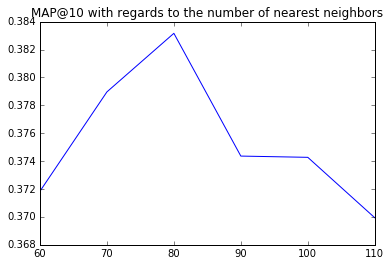

In [72]:
figure_best_knn_tfidf = plt.figure()
plt.plot(score_knn_tfidf.knn, score_knn_tfidf.score)
plt.title('MAP@10 with regards to the number of nearest neighbors')

figure_best_knn_tfidf.savefig(path_to_results + 'best_knn_tfidf.png')

## KNN with Glove embeddings

This following part is inspired from the previous part and a TP made in Deep Learning class.

In [78]:
#Download the Glove data

import os.path as op
import zipfile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# Get pretrained Glove Word2Vec, 32Mo
URL_REPRESENTATIONS = "https://github.com/m2dsupsdlclass/lectures-labs/releases/download/0.3/glove100k.100d.zip"
ZIP_REPRESENTATIONS = "glove100k.100d.zip"
FILE_REPRESENTATIONS = "glove100K.100d.txt"

if not op.exists(path_to_results + ZIP_REPRESENTATIONS):
    print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, path_to_results + ZIP_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, path_to_results + ZIP_REPRESENTATIONS)
    
if not op.exists(path_to_results + FILE_REPRESENTATIONS):
    print("extracting %s..." %(path_to_results + ZIP_REPRESENTATIONS))
    myzip = zipfile.ZipFile(path_to_results + ZIP_REPRESENTATIONS)
    myzip.extractall(path_to_results)

extracting ../results/glove100k.100d.zip...


In [79]:
embeddings_index = {}
embeddings_vectors = []
f = open(path_to_results + 'glove100K.100d.txt', encoding='utf8')

word_idx = 0
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()

inv_index = {v:k for k,v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 100000 different words in the file


In [80]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_embeddings_norm = glove_embeddings / np.linalg.norm(glove_embeddings, axis = -1, keepdims=True)
print(glove_embeddings.shape)

(100000, 100)


In [81]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

def get_emb_sentence(sentence):
    tokens = sentence.split()
    vector = np.zeros(100)
    count = 1
    for token in tokens:
        try:
            vector += get_emb(token)
            count += 1
        except Exception as e:
            pass
    return vector / count

def most_similar_sentence(sentence, topn=10):
    emb = get_emb_sentence(sentence)
    emb = emb / np.linalg.norm(emb)
    # Large numpy vector with all cosine similarities between emb and all other words
    cosines = np.dot(glove_embeddings_norm, emb)
    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1]#[:topn]
    idxs = [i for i in idxs if inv_index[i] not in all_stopwords][:topn]
    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

most_similar_sentence("This message is made to fire you from the company")

[('one', 0.89331493172937471),
 ('well', 0.8785990901546924),
 ('.', 0.8754558355592349),
 ('made', 0.87075033287081982),
 ('way', 0.87009467707329213),
 ('would', 0.86937656576841738),
 ('even', 0.86250095570597418),
 ('time', 0.85478175059425743),
 ('could', 0.85408966017161292),
 ('make', 0.8540104864158572)]

In [82]:
# Get sentence vectors
training_df_train['sentence_vec'] = training_df_train.clean_body.apply(lambda x: get_emb_sentence(x))

C:\Users\Mehdi\Annexes\PythonENSAE_v2\python\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [83]:
# Here, we create the matrix of embeddings similar to the TFIDF matrix
# Take 4 minutes
embedding_glove_train = training_df_train.sentence_vec[0]
for i in tqdm(range(len(training_df_train))):
    embedding_glove_train = np.vstack((embedding_glove_train, training_df_train.sentence_vec[i]))
embedding_glove_train.shape

(31606, 100)

In [84]:
#Prediction on test
# Takes approximatly 5 minutes
training_df_test["pred_knn_glove"] = None

for row in tqdm(range(1000)):
    body = training_df_test['clean_body'][row]
    date = training_df_test['date'][row]
    sender = training_df_test['sender'][row]
    
    mail_glove = get_emb_sentence(body).reshape(1, -1)
    
    training_df_test["pred_knn_glove"][row] = prediction_knn_embedding(mail_glove, date, sender, embedding_glove_train, training_df_train, knn = 60)

In [85]:
#Score MAP@10
#Score for each prediction with Glove embeddings and knn methods
training_df_test['score_knn_glove'] = None

for row in tqdm(range(1000)): #for each mail
    training_df_test['score_knn_glove'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_knn_glove'][row])

In [86]:
print('\x1b[0;30;43m' + 
      'The MAP@10 score with knn with Glove embeddings is approximatly %.5f.' 
      %np.mean(training_df_test['score_knn_glove'][:1000]) + 
      '\x1b[0m')

The MAP@10 score with knn with Glove embeddings is approximatly 0.29792.


### Choice of the best hyperparameter knn

In [87]:
# All these parameters will be tested
vect_knn = np.arange(40, 90, 10)
score_knn_glove = pd.DataFrame()

max_size = 200
for _, knn in enumerate(vect_knn):
    print('knn : ', knn, '\t(', _ +1 , '/', len(vect_knn), ')')
    for row in range(max_size): #test on a subset
        body = training_df_test['clean_body'][row]
        date = training_df_test['date'][row]
        sender = training_df_test['sender'][row]

        mail_glove = get_emb_sentence(body).reshape(1, -1)
    
        training_df_test["pred_knn_glove"][row] = prediction_knn_embedding(mail_glove, date, sender, embedding_glove_train, training_df_train, knn=knn)
        training_df_test['score_knn_glove'][row] = apk(training_df_test['recipients'][row].split(' '), training_df_test['pred_knn_glove'][row])
    
    score = round(np.mean(training_df_test['score_knn_glove'][:max_size]),5)
    score_knn_glove = score_knn_glove.append(pd.DataFrame({'knn' : [knn], 'score':[score]}), ignore_index = True)

knn :  40 	( 1 / 5 )
knn :  50 	( 2 / 5 )
knn :  60 	( 3 / 5 )
knn :  70 	( 4 / 5 )
knn :  80 	( 5 / 5 )


In [88]:
score_knn_glove

,knn,score
0,40,0.28666
1,50,0.27957
2,60,0.28631
3,70,0.28556
4,80,0.28423


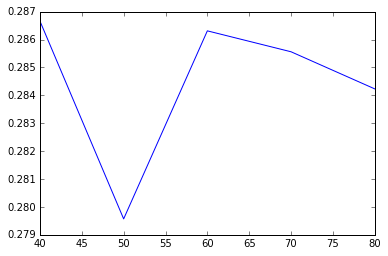

In [89]:
plt.plot(score_knn_glove.knn, score_knn_glove.score)

# Summary

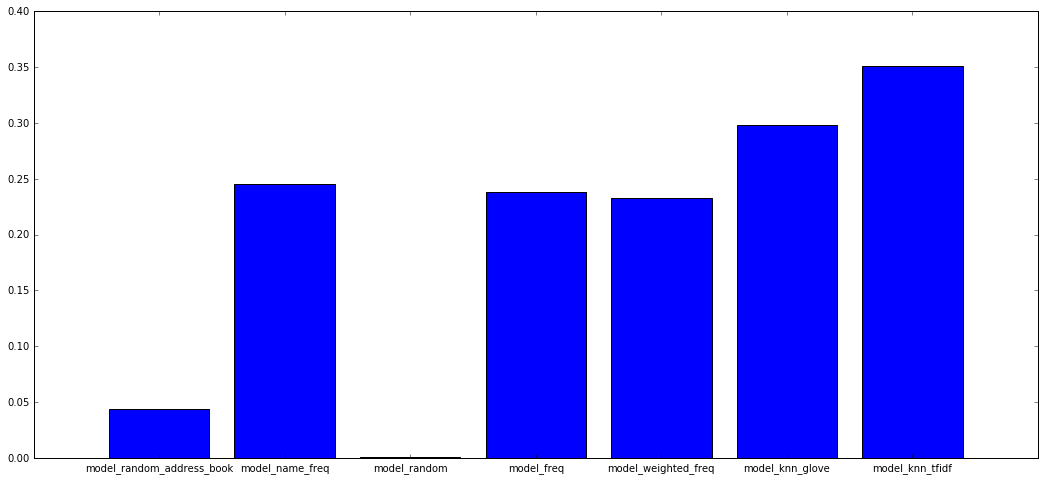

In [90]:
model_score = {'model_random' : np.mean(training_df_test['score_random']),
               'model_random_address_book' : np.mean(training_df_test['score_random_address_book']),
               'model_freq' : np.mean(training_df_test['score_freq']),
               'model_weighted_freq' : np.mean(training_df_test['score_weighted_freq']),
               'model_name_freq' : np.mean(training_df_test['score_name_freq']),
               'model_knn_tfidf' : np.mean(training_df_test['score_knn_tfidf'][:1000]),
               'model_knn_glove' : np.mean(training_df_test['score_knn_glove'][:1000])}

figure_model_score = plt.figure(figsize=(18, 8))

plt.bar(range(len(model_score)), model_score.values(), align='center')
plt.xticks(range(len(model_score)), model_score.keys())

figure_model_score.savefig(path_to_results + 'model_score.png')

The best model is `model_knn_tfidf` : the score is around 0.35 (there is a mysterious negative biais)

# Application on the real test dataset

## Handy structures based on the complete training dataset

In [91]:
# Construct the address book for each sender, take 3 minutes, on the complete training dataset
address_books = get_address_books(training_info, training_set)

In [92]:
# save all unique sender names
emails_ids_per_sender = get_mids_per_sender(training_set)
all_senders = emails_ids_per_sender.keys()

# save all unique recipient names    
all_recs = list(set([elt[0] for sublist in address_books.values() for elt in sublist]))

# save all unique user names 
all_users = []
all_users.extend(all_senders)
all_users.extend(all_recs)
all_users = list(set(all_users))

In [93]:
# Takes 3 minutes
mids_sender_to_recipient = get_mids_sender_to_recipient(address_books, training_df)

In [94]:
#Mails received by user
mids_received_by_user = get_mids_received_by_user(training_df)

In [95]:
test_df.head()

,mid,sender,date,body,body_rt,body_rf,clean_body
0,284098,jonathan.mckay@enron.com,2001-11-02 05:25:29,"How is everyone.....mother, child.........fath...","How is everyone.....mother, child.........fath...","How is everyone.....mother, child.........fath...",everyone mother child father hope everything w...
1,272008,dutch.quigley@enron.com,2001-11-02 05:34:55,-----Original Message-----From: \tWesner-Soon...,-----Original Message-----From: Wesner-Soong...,-----Original Message----- FW: Contracts that...,original message fw contracts need xpitted out...
2,49273,james.d.steffes@enron.com,2001-11-02 05:57:55,Janine -Ok for you to cover the whole country....,Janine -Ok for you to cover the whole country....,Janine -Ok for you to cover the whole country....,janine ok cover whole country forgotten discus...
3,71901,kim.ward@enron.com,2001-11-02 06:10:47,when?,when?,when?,NaN
4,82354,barry.tycholiz@enron.com,2001-11-02 06:17:44,WOW.... I am positive that your beautiful wife...,WOW.... I am positive that your beautiful wife...,WOW.... I am positive that your beautiful wife...,wow positive beautiful wife sign hauling three...


## Most frequent recipients

In [96]:
#Make some predictions on the real test dataset
predictions_frequency = predictions_frequency_per_sender(training_set, address_books)

#Fill the dataframe
test_df['pred_freq'] = None
for row in range(test_df.shape[0]): #for each mail
    sender = test_df['sender'][row]

    #random prediction
    test_df['pred_freq'][row] = predictions_frequency[sender]    

## KNN with TFIDF embeddings

In [97]:
#In this part, the mid will be an integer and not a string
training_df['mid'] = training_df['mid'].astype(int)

In [98]:
# Embedding with TFIDF
all_mails_tfidf = tfidf.fit_transform(training_df['clean_body'].values)

In [99]:
#Prediction on test
test_df["pred_knn_tfidf"] = None

for row in tqdm(range(test_df.shape[0])):
    try: #if the body is not empty due to cleaning
        body = test_df['clean_body'][row]
        date = test_df['date'][row]
        sender = test_df['sender'][row]

        mail_tfidf = tfidf.transform([body])

        test_df["pred_knn_tfidf"][row] = prediction_knn_embedding(mail_tfidf, date, sender, all_mails_tfidf, training_df, knn=80, is_weighted_date=True)
    except: #when the text is empty, one uses the frequency based model
        test_df["pred_knn_tfidf"][row] = predictions_frequency[sender]   

## KNN with Glove embeddings

In [100]:
# Get sentence vectors
training_df['sentence_vec'] = training_df.clean_body.apply(lambda x: get_emb_sentence(x))

#Get the matrix of embeddings 
all_mails_glove = training_df.sentence_vec[0]
for i in tqdm(range(len(training_df))):
    all_mails_glove = np.vstack((all_mails_glove, training_df.sentence_vec[i])) 

In [101]:
#Prediction on the real test
test_df["pred_knn_glove"] = None

for row in tqdm(range(test_df.shape[0])):
    try: #if the body is not empty due to cleaning
        body = test_df['clean_body'][row]
        date = test_df['date'][row]
        sender = test_df['sender'][row]

        mail_glove = get_emb_sentence(body).reshape(1, -1)

        test_df["pred_knn_glove"][row] = prediction_knn_embedding(mail_glove, date, sender, embedding_glove, training_df, knn = 60)  
    except: #when the text is empty, one uses the frequency based model
        test_df["pred_knn_glove"][row] = predictions_frequency[sender] 

# Write 

In [102]:
#Write the prediction in a txt file

name = 'pred_knn_tfidf' #'pred_freq', 'pred_knn_tfidf', 'pred_knn_glove'

with open(path_to_results + name + '.txt', 'wb') as my_file:
    my_file.write(bytes('mid,recipients' + '\n', 'UTF-8'))
    for row in range(test_df.shape[0]):
        mid = test_df['mid'][row]
        preds = test_df[name][row]
        my_file.write(bytes(str(mid) + ',' + ' '.join(preds) + '\n', 'UTF-8'))

In [103]:
#Test on the size
test_df_written = pd.read_csv(path_to_results + name + '.txt')
test_df_written.shape[0] == test_df.shape[0]

True